In [1]:
import torch
# This is to improve performance on M1 Macs
def get_best_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_best_device()


from datasets import load_dataset

imdb_dataset = load_dataset("imdb")

splits = ["train", "test"]
# Modified to select only 1000 records from each split
imdb_dataset = {
    'train': imdb_dataset['train'].shuffle(seed=42).select(range(250)),
    'test': imdb_dataset['test'].shuffle(seed=42).select(range(250))
}



# Thin out the dataset to make it run faster for this example

# Experiment with the DeepSeek model to see what you can do.

from transformers import (
GPT2Model, DeepseekV3Model,
    BertForSequenceClassification,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    TrainingArguments,
    Trainer,
BertTokenizer
)

model_name = "textattack/bert-base-uncased-imdb"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Tokenize the input sequence
tokenizer = BertTokenizer.from_pretrained(model_name)


# model = DistilBertForSequenceClassification.from_pretrained(
#     "distilbert-base-uncased", num_labels=2
# )
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

imdb_dataset_tokenized = {}
#imdb_dataset.map(tokenize_function, batched=True)

for split in splits:
    imdb_dataset_tokenized[split] = imdb_dataset[split].map(tokenize_function, batched=True)

training_args = TrainingArguments(
    per_device_train_batch_size=64,
    output_dir="./results",
    learning_rate=2e-5,
    logging_steps=10,
    num_train_epochs=1,
    save_strategy="no",              # Don't save checkpoints to save time
    fp16=False                        # Use mixed precision if your hardware supports it

)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_dataset_tokenized["train"],
    eval_dataset=imdb_dataset_tokenized["test"],
)

print(imdb_dataset['train'].shape)
trainer.train()

(250, 2)


Step,Training Loss


TrainOutput(global_step=4, training_loss=0.16111937165260315, metrics={'train_runtime': 139.2131, 'train_samples_per_second': 1.796, 'train_steps_per_second': 0.029, 'total_flos': 65777763840000.0, 'train_loss': 0.16111937165260315, 'epoch': 1.0})

In [4]:
evaluation_results = trainer.evaluate()
print(evaluation_results)

{'eval_loss': 0.40791648626327515, 'eval_runtime': 4.5146, 'eval_samples_per_second': 55.376, 'eval_steps_per_second': 7.088, 'epoch': 1.0}


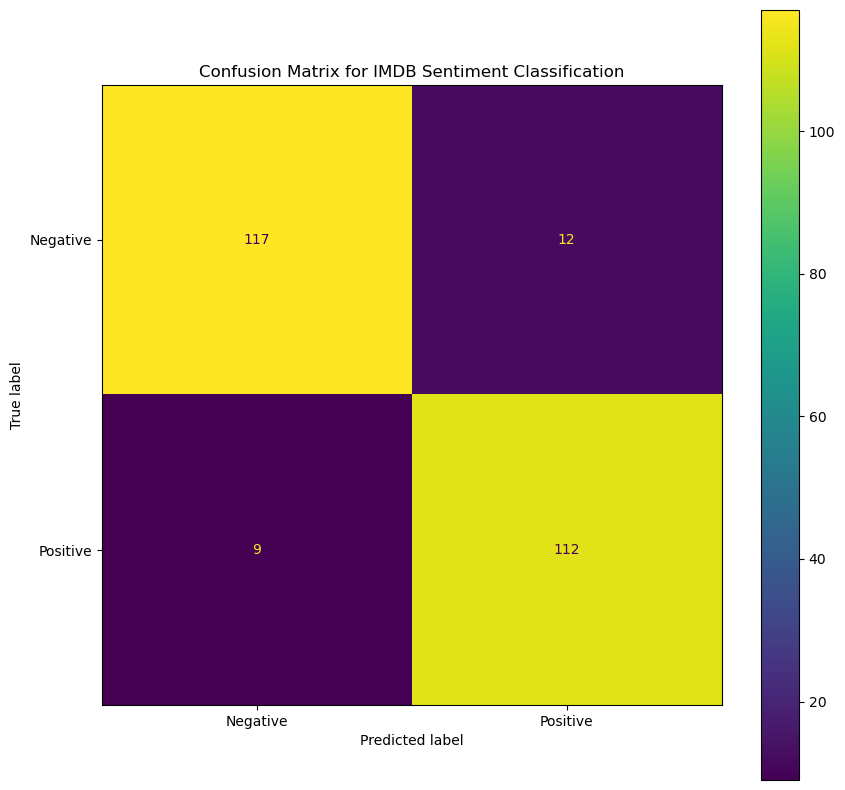

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the model
predictions = trainer.predict(imdb_dataset_tokenized["test"])

# Extract predicted labels and true labels
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
labels = ["Negative", "Positive"]  # IMDB sentiment labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title("Confusion Matrix for IMDB Sentiment Classification")
plt.show()
